# **KLASIFIKASI GAMBAR BUAH DENGAN TENSORFLOW**

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import gdown
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Data Loading**

In [ ]:
#membaca dataset https://drive.google.com/file/d/1q2L-ZeSw_cfFdcBfOIJlHDBs9EuqxcN8/view?usp=sharing
file_id = "1q2L-ZeSw_cfFdcBfOIJlHDBs9EuqxcN8"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1q2L-ZeSw_cfFdcBfOIJlHDBs9EuqxcN8
From (redirected): https://drive.google.com/uc?id=1q2L-ZeSw_cfFdcBfOIJlHDBs9EuqxcN8&confirm=t&uuid=09268b8a-ecab-4c6a-8930-24f32a66725d
To: /content/dataset.zip
100%|██████████| 166M/166M [00:04<00:00, 35.5MB/s]


'dataset.zip'

In [5]:
%%capture
!unzip /content/dataset.zip

In [7]:
dataset_path = '/content/dataset_buah'

os.listdir(dataset_path)

['Train', 'Validation', 'Test']

In [8]:
train_dir = os.path.join(dataset_path, 'Train')
test_dir = os.path.join(dataset_path, 'Test')
val_dir = os.path.join(dataset_path, 'Validation')

In [9]:
apel_dir = os.path.join(train_dir, 'Apel')
jeruk_dir = os.path.join(train_dir, 'Jeruk')
pisang_dir = os.path.join(train_dir, 'Pisang')

print('total training Apel images:', len(os.listdir(apel_dir)))
print('total training Jeruk images:', len(os.listdir(jeruk_dir)))
print('total training Pisang images:', len(os.listdir(pisang_dir)))

apel_files = os.listdir(apel_dir)
print(apel_files[:10])
jeruk_files = os.listdir(jeruk_dir)
print(jeruk_files[:10])
pisang_files = os.listdir(pisang_dir)
print(pisang_files[:10])

total training Apel images: 3870
total training Jeruk images: 3870
total training Pisang images: 3870
['A4 (48).jpg', 'A8 (30).jpg', 'A2 (68).jpg', 'A2 (26).jpg', 'A2 (61).jpg', 'A3 (232).jpg', 'A7 (217).jpg', 'A5 (287).jpg', 'A5 (226).jpg', 'A4 (105).jpg']
['J6 (549).jpg', 'J6 (184).jpg', 'J4 (142).jpg', 'J2 (59).jpg', 'J8 (182).jpg', 'J8 (65).JPG', 'J1 (96).jpg', 'J3 (285).jpg', 'J8 (183).jpg', 'J4 (477).jpg']
['P19 (71).JPG', 'P8 (17).jpg', 'P10 (65).jpg', 'P3 (299).jpg', 'P9 (90).jpg', 'P8 (55).jpg', 'P2 (40).jpg', 'P13 (89).jpg', 'P19 (267).JPG', 'P3 (414).jpg']


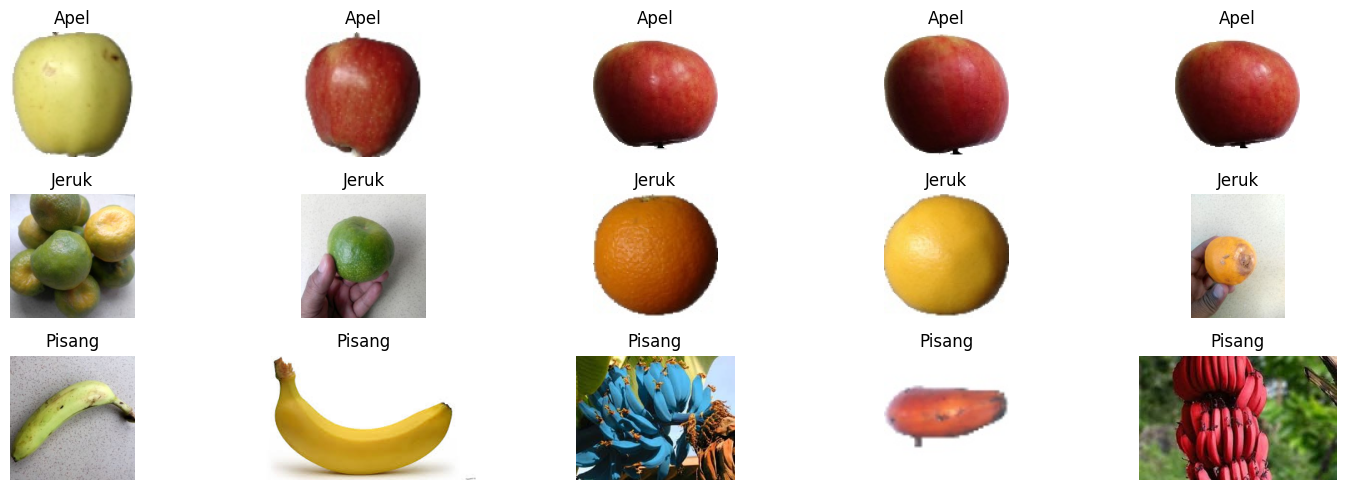

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

buah_dirs = [apel_dir, jeruk_dir, pisang_dir]
buah_labels = ['Apel', 'Jeruk', 'Pisang']
buah_files = [apel_files, jeruk_files, pisang_files]

plt.figure(figsize=(15, 5))
for i in range(3):
    for j in range(5):
        img_path = os.path.join(buah_dirs[i], buah_files[i][j])
        img = Image.open(img_path)

        plt.subplot(3, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(buah_labels[i])
        plt.axis('off')

plt.tight_layout()
plt.show()


# **Data Augmentation**

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
    rotation_range=40,  # Rotasi gambar secara acak
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2,  # Geser gambar secara vertikal
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Zoom in/out gambar
    horizontal_flip=True,  # Membalik gambar secara horizontal
    fill_mode='nearest'  # Pengisian ulang piksel yang kosong akibat transformasi
)

val_datagen = ImageDataGenerator(rescale=1./255)

## **Model CNN**

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [20]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,105,611 (217.84 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,070,408 (145.23 MB)

None


## **Data Generator**

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping]
)

Found 11610 images belonging to 3 classes.
Found 1740 images belonging to 3 classes.
Epoch 1/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.9825 - loss: 0.0609 - val_accuracy: 0.9809 - val_loss: 0.0661
Epoch 2/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9803 - val_loss: 0.0564
Epoch 3/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9856 - loss: 0.0512 - val_accuracy: 0.9792 - val_loss: 0.0819
Epoch 4/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9809 - val_loss: 0.0696
Epoch 5/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.9850 - loss: 0.0478 - val_accuracy: 0.9850 - val_loss: 0.0455


## **Plotting Akurasi dan Loss**

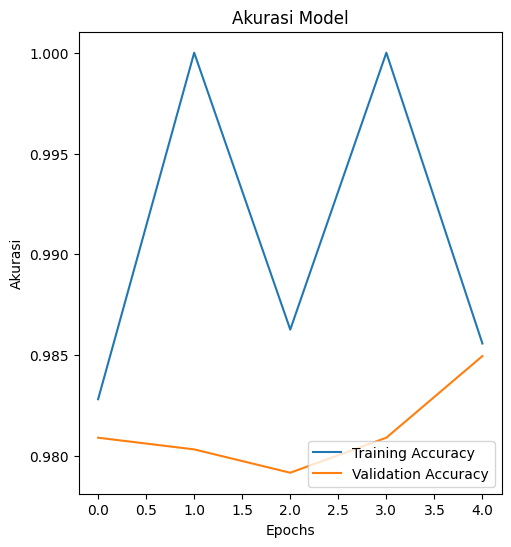

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend()

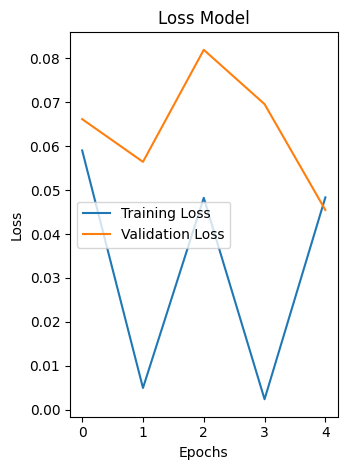

In [24]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Save Model**

In [25]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [26]:
model.save("model.h5")

## **TFJS**

In [27]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [28]:
import tensorflowjs as tfjs

# Direktori tujuan
tfjs_target_dir = 'tfjs_model'

# Simpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, tfjs_target_dir)

print(f"Model TFJS berhasil disimpan di: {tfjs_target_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
Model TFJS berhasil disimpan di: tfjs_model


## **TF-Lite**

In [29]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan file .tflite
tflite_dir = 'tflite'
os.makedirs(tflite_dir, exist_ok=True)
with open(os.path.join(tflite_dir, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

print(f"Model TFLite berhasil disimpan di: {tflite_dir}/model.tflite")

Saved artifact at '/tmp/tmpky__vef2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132988369486864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369490320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369489744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369491088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369490512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369491856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369491280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369492624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369492048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132988369493392: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model TFLite 

In [31]:
class_names = ['Apel', 'Jeruk', 'Pisang']

In [32]:
label_file = os.path.join(tflite_dir, 'label.txt')
with open(label_file, 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

print(f"Label berhasil disimpan di: {label_file}")

Label berhasil disimpan di: tflite/label.txt


## **Inference model dan TF-Lite**

Saving A9 (32).jpg to A9 (32).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


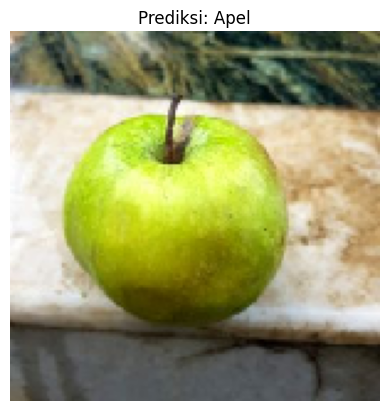

In [38]:
from google.colab import files

uploaded = files.upload()
model = tf.keras.models.load_model('model.h5')
class_names = ['Apel', 'Jeruk', 'Pisang']

for filename in uploaded.keys():
    # Load dan resize gambar
    img_path = filename
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prediksi
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Tampilkan gambar + hasil prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class}")
    plt.show()

Saving J6 (26).JPG to J6 (26) (1).JPG
Prediksi: Jeruk


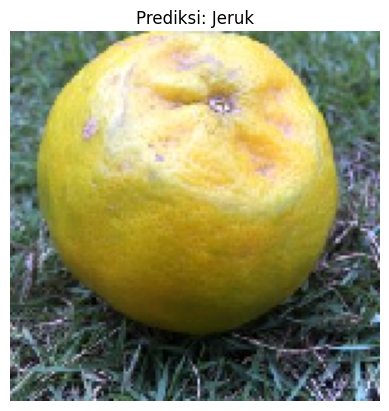

In [42]:
from tensorflow.lite.python.interpreter import Interpreter
# Langkah 1: Upload gambar
uploaded = files.upload()
img_path = next(iter(uploaded))

# Langkah 2: Load gambar dan pre-processing
img = image.load_img(img_path, target_size=(150, 150))  # Sesuaikan dengan ukuran input model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi

# Langkah 3: Muat model TF-Lite
model_path = "/content/tflite/model.tflite"  # Path ke model TF-Lite
interpreter = Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Langkah 4: Persiapkan input dan output tensor untuk model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Langkah 5: Lakukan prediksi
interpreter.invoke()
predictions = interpreter.get_tensor(output_details[0]['index'])

# Langkah 6: Ambil kelas yang diprediksi
predicted_class = np.argmax(predictions)

# Langkah 7: Tampilkan hasil
class_names = ['Apel', 'Jeruk', 'Pisang']  # Sesuaikan dengan label yang digunakan
print(f"Prediksi: {class_names[predicted_class]}")

# Tampilkan gambar
plt.imshow(img)
plt.title(f"Prediksi: {class_names[predicted_class]}")
plt.axis('off')
plt.show()

In [33]:
# Kompres folder ke dalam file zip
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')
shutil.make_archive('/content/tflite', 'zip', '/content/tflite')
shutil.make_archive('/content/mymodel', 'zip', '/content/mymodel')

'/content/mymodel.zip'